# Deep Learning Models Training
This notebook trains MLP, LSTM, and GRU models for glucose prediction using the existing training pipeline.

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set


In [8]:
import os
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add training directory to path
# sys.path.append('training')
sys.path.append('/content/drive/MyDrive/Granada-miei/Granada-evaluate-val-set/training')

from split_data import load_splits, rescale_data, print_results
from utils_dnn import (
    create_model,
    prepare_data,
    train_model,
    predict_in_batches,
    print_model_summary,
)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configuration

In [9]:
# Training configuration
MODELS = ["mlp", "lstm", "gru"]
BATCH_SIZE = 4096
EPOCHS = 100
LEARNING_RATE = 0.01
SEED = 42
OUTPUT_PATH = "outputs"

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Set random seed for reproducibility
tf.keras.utils.set_random_seed(SEED)

print(f"Training configuration:")
print(f"Models: {MODELS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Random seed: {SEED}")

Training configuration:
Models: ['mlp', 'lstm', 'gru']
Batch size: 4096
Epochs: 100
Learning rate: 0.01
Random seed: 42


## Load Data

In [10]:
# Load pre-prepared data splits
print("Loading pre-prepared data splits...")
train_set, val_set, test_set, X_cols, y_cols = load_splits()

print(f"\nDataset sizes:")
print(f"Train set: {len(train_set)} samples")
print(f"Validation set: {len(val_set)} samples")
print(f"Test set: {len(test_set)} samples")
print(f"\nFeatures: {len(X_cols)} columns")
print(f"Targets: {len(y_cols)} columns")
print(f"\nX columns: {X_cols}")
print(f"y columns: {y_cols}")

Loading pre-prepared data splits...

Dataset sizes:
Train set: 14058224 samples
Validation set: 1861178 samples
Test set: 3945594 samples

Features: 8 columns
Targets: 1 columns

X columns: ['lag105', 'lag90', 'lag75', 'lag60', 'lag45', 'lag30', 'lag15', 'lag0']
y columns: ['lead30']


## Training Function

In [11]:
def train_deep_model(model_name, train_set, val_set, X_cols, y_cols,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, lr=LEARNING_RATE):
    """
    Train a deep learning model using the existing pipeline
    """
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name.upper()} MODEL")
    print(f"{'='*60}")

    # Prepare data for TensorFlow
    print("Preparing data for TensorFlow...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
        train_set, val_set, test_set, X_cols, y_cols, model_name
    )

    print(f"Data shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

    # Create model
    print(f"\nCreating {model_name.upper()} model...")
    model = create_model(model_name)
    print_model_summary(model)

    # Train model
    print(f"\nTraining {model_name.upper()} model...")
    model, history = train_model(
        model, X_train, y_train, X_val, y_val,
        epochs=epochs, batch_size=batch_size,
        initial_learning_rate=lr,
        output_path=OUTPUT_PATH, exp_name=model_name
    )

    # Evaluate on validation set
    print("\nEvaluating model...")
    val_set_copy = val_set.copy()
    val_set_copy["y_pred"] = predict_in_batches(
        model, val_set_copy[X_cols], model_name, batch_size
    ).flatten()

    # Prepare results
    val_set_copy = val_set_copy.rename(columns={y_cols[-1]: "target"})
    val_set_copy = rescale_data(val_set_copy, ["target", "y_pred"])

    # Select output columns and save
    output_columns = ["Timestamp", "Patient_ID", "bgClass", "target", "y_pred"]
    results = val_set_copy[output_columns]

    # Print evaluation results
    print_results(results)

    # Save results
    output_file = f"{OUTPUT_PATH}/{model_name}_output.csv"
    results.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")

    return model, history, results

## Train All Models

In [12]:
# Store results for comparison
training_results = {}
training_histories = {}

# Train each model
for model_name in MODELS:
    try:
        model, history, results = train_deep_model(
            model_name, train_set, val_set, X_cols, y_cols
        )

        training_results[model_name] = results
        training_histories[model_name] = history

        print(f"\n✅ {model_name.upper()} training completed successfully!")

    except Exception as e:
        print(f"\n❌ Error training {model_name.upper()}: {str(e)}")
        continue

print(f"\n{'='*60}")
print("ALL TRAINING COMPLETED")
print(f"{'='*60}")
print(f"Successfully trained models: {list(training_results.keys())}")


TRAINING MLP MODEL
Preparing data for TensorFlow...
Data shapes:
X_train: (14058224, 8), y_train: (14058224,)
X_val: (1861178, 8), y_val: (1861178,)

Creating MLP model...

Model Architecture:


Model: "MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,353 (267.00 KB)

 Trainable params: 68,353 (267.00 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 68,353

Training MLP model...
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0143 - mae: 0.0957  
Epoch 1: val_loss improved from inf to 0.00608, saving model to outputs/mlp.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0141 - mae: 0.0954 - val_loss: 0.0061 - val_mae: 0.0783 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.0063 - mae: 0.0805
Epoch 2: val_loss improved from 0.00608 to 0.00598, saving model to outputs/mlp.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 4s 982us/step - loss: 0.0063 - mae: 0.0805 - val_loss: 0.0060 - val_mae: 0.0777 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.0203 - mae: 0.1020
Epoch 3: val_loss did not improve from 0.00598
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 4s 980us/step - loss: 0.0205 - mae: 0.1024 - val_loss: 0.0061 - val_mae: 0.0786 - learning_rate: 0.0100
Epoch 4/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss:

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 75)          │        23,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 75)             │        45,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,476 (267.48 KB)

 Trainable params: 68,476 (267.48 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 68,476

Training LSTM model...
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0069 - mae: 0.0832
Epoch 1: val_loss improved from inf to 0.00581, saving model to outputs/lstm.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 70s 18ms/step - loss: 0.0068 - mae: 0.0831 - val_loss: 0.0058 - val_mae: 0.0775 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0778
Epoch 2: val_loss improved from 0.00581 to 0.00578, saving model to outputs/lstm.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 0.0059 - mae: 0.0778 - val_loss: 0.0058 - val_mae: 0.0769 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0059 - mae: 0.0774
Epoch 3: val_loss improved from 0.00578 to 0.00565, saving model to outputs/lstm.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - loss: 0.0059 - mae: 0.0774 - val_loss: 0.0057 - val_mae: 0.0757 - learning_rate: 0.0100
Epoch 4/100
3329/3

Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 86)          │        22,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 86)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 86)             │        44,892 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            87 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,941 (265.39 KB)

 Trainable params: 67,941 (265.39 KB)

 Non-trainable params: 0 (0.00 B)


Total parameters: 67,941

Training GRU model...
Epoch 1/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0070 - mae: 0.0833
Epoch 1: val_loss improved from inf to 0.00586, saving model to outputs/gru.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - loss: 0.0070 - mae: 0.0832 - val_loss: 0.0059 - val_mae: 0.0779 - learning_rate: 0.0100
Epoch 2/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0060 - mae: 0.0779
Epoch 2: val_loss improved from 0.00586 to 0.00585, saving model to outputs/gru.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - loss: 0.0060 - mae: 0.0779 - val_loss: 0.0058 - val_mae: 0.0771 - learning_rate: 0.0100
Epoch 3/100
3329/3433 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0059 - mae: 0.0777
Epoch 3: val_loss improved from 0.00585 to 0.00581, saving model to outputs/gru.weights.h5
3433/3433 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - loss: 0.0059 - mae: 0.0777 - val_loss: 0.0058 - val_mae: 0.0769 - learning_rate: 0.0100
Epoch 4/100
3329/3433 

Cumulative
Samples: 1861178
MAE: 13.62(2.02)
MAPE: 9.54(1.65)
RMSE: 18.82(2.82)
~~~~~~~~~~
Normal
Samples: 1147765
MAE: 12.32(1.90)
MAPE: 10.08(1.66)
RMSE: 17.16(2.69)
~~~~~~~~~~
Hyper
Samples: 614538
MAE: 16.01(2.25)
MAPE: 6.97(0.89)
RMSE: 21.69(2.96)
~~~~~~~~~~
Hypo
Samples: 98875
MAE: 13.54(2.62)
MAPE: 22.87(4.56)
RMSE: 17.49(3.66)

Results saved to: outputs/gru_output.csv

✅ GRU training completed successfully!

ALL TRAINING COMPLETED
Successfully trained models: ['mlp', 'lstm', 'gru']


## Visualize Training History

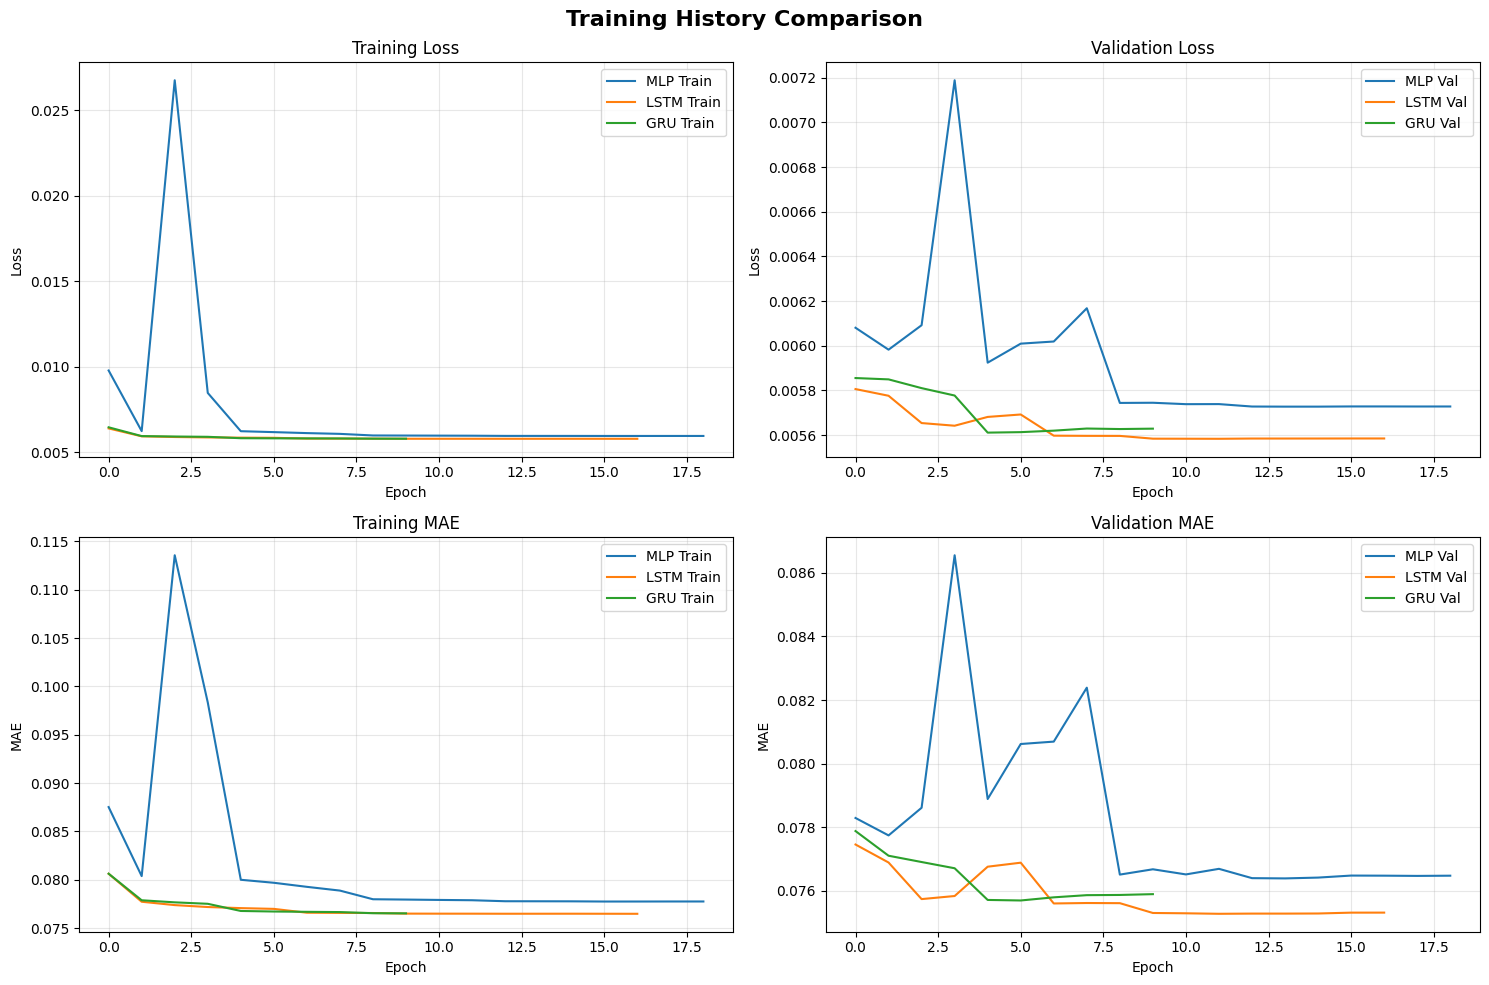

Training history plot saved to outputs/training_history_comparison.png


In [13]:
# Plot training histories
if training_histories:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Comparison', fontsize=16, fontweight='bold')

    # Loss plots
    for model_name, history in training_histories.items():
        axes[0, 0].plot(history.history['loss'], label=f'{model_name.upper()} Train')
        axes[0, 1].plot(history.history['val_loss'], label=f'{model_name.upper()} Val')

    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # MAE plots
    for model_name, history in training_histories.items():
        axes[1, 0].plot(history.history['mae'], label=f'{model_name.upper()} Train')
        axes[1, 1].plot(history.history['val_mae'], label=f'{model_name.upper()} Val')

    axes[1, 0].set_title('Training MAE')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Validation MAE')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}/training_history_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Training history plot saved to {OUTPUT_PATH}/training_history_comparison.png")

## Results Summary

In [14]:
# Calculate summary metrics for each model
if training_results:
    from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

    summary_data = []

    for model_name, results in training_results.items():
        mae = mean_absolute_error(results['target'], results['y_pred'])
        rmse = root_mean_squared_error(results['target'], results['y_pred'])
        mape = mean_absolute_percentage_error(results['target'], results['y_pred']) * 100

        summary_data.append({
            'Model': model_name.upper(),
            'MAE': f"{mae:.2f}",
            'RMSE': f"{rmse:.2f}",
            'MAPE (%)': f"{mape:.2f}",
            'Samples': len(results)
        })

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*60)
    print("MODELS PERFORMANCE SUMMARY")
    print("="*60)
    print(summary_df.to_string(index=False))

    # Save summary
    summary_df.to_csv(f"{OUTPUT_PATH}/dnn_models_summary.csv", index=False)
    print(f"\nSummary saved to {OUTPUT_PATH}/dnn_models_summary.csv")


MODELS PERFORMANCE SUMMARY
Model   MAE  RMSE MAPE (%)  Samples
  MLP 13.75 19.26     9.89  1861178
 LSTM 13.55 19.02     9.74  1861178
  GRU 13.63 19.07     9.81  1861178

Summary saved to outputs/dnn_models_summary.csv


## Model Comparison Visualization

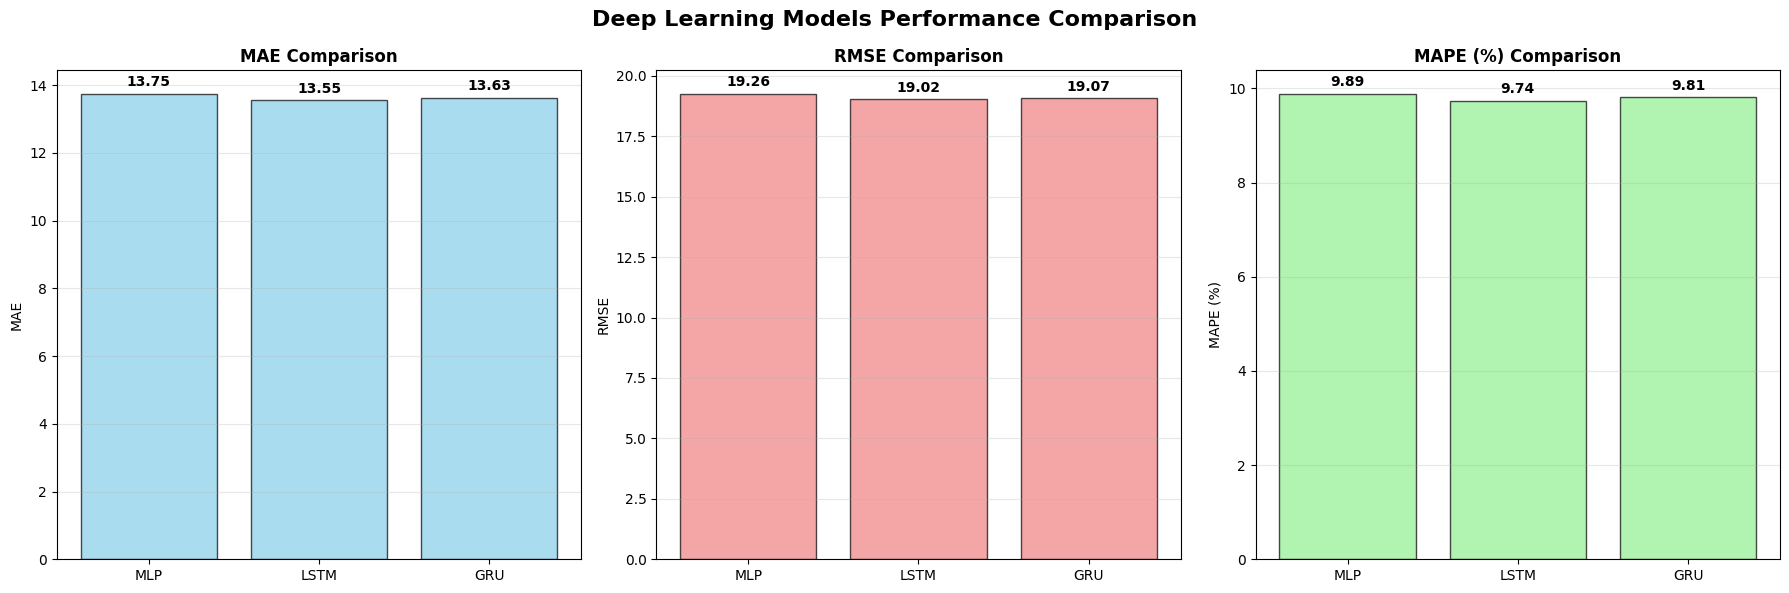

Comparison plot saved to outputs/dnn_models_comparison.png


In [15]:
# Create comparison plots
if len(training_results) > 1:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Deep Learning Models Performance Comparison', fontsize=16, fontweight='bold')

    metrics = ['MAE', 'RMSE', 'MAPE (%)']
    colors = ['skyblue', 'lightcoral', 'lightgreen']

    for i, metric in enumerate(metrics):
        values = [float(row[metric]) for row in summary_data]
        models = [row['Model'] for row in summary_data]

        bars = axes[i].bar(models, values, color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{metric} Comparison', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
                        f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}/dnn_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Comparison plot saved to {OUTPUT_PATH}/dnn_models_comparison.png")

## Final Summary

In [16]:
print("\n" + "="*80)
print("DEEP LEARNING TRAINING PIPELINE COMPLETED")
print("="*80)
print(f"\n📁 Output directory: {OUTPUT_PATH}")
print(f"🎯 Models trained: {len(training_results)}")
print(f"📊 Results files generated:")

# List all generated files
output_files = [
    f"{model_name}_output.csv" for model_name in training_results.keys()
]
output_files.extend([
    "dnn_models_summary.csv",
    "training_history_comparison.png",
    "dnn_models_comparison.png"
])

for file in output_files:
    if os.path.exists(f"{OUTPUT_PATH}/{file}"):
        print(f"   ✅ {file}")
    else:
        print(f"   ❌ {file} (not found)")

if training_results:
    best_model = min(summary_data, key=lambda x: float(x['MAE']))
    print(f"\n🏆 Best performing model: {best_model['Model']} (MAE: {best_model['MAE']} mg/dl)")

print("\n" + "="*80)


DEEP LEARNING TRAINING PIPELINE COMPLETED

📁 Output directory: outputs
🎯 Models trained: 3
📊 Results files generated:
   ✅ mlp_output.csv
   ✅ lstm_output.csv
   ✅ gru_output.csv
   ✅ dnn_models_summary.csv
   ✅ training_history_comparison.png
   ✅ dnn_models_comparison.png

🏆 Best performing model: LSTM (MAE: 13.55 mg/dl)

